**计算polya尾巴上的非A碱基修饰**

In [1]:
from collections import defaultdict, namedtuple, Counter
import pickle
import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import pyranges as pr
import pysam
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import variation, gaussian_kde, pearsonr, mannwhitneyu
from Bio import SeqIO

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(filename)s: %(message)s',
                    datefmt='%m/%d/%Y %I:%M:%S %p',
                    )

In [3]:
%config InlineBackend.figure_format = 'retina'

# 设置全局字体
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
font_dirs = ["/public/home/mowp/test/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "Arial"
plt.rcParams['font.size'] = 12
plt.rcParams['svg.fonttype'] = 'none'

In [4]:
gene_model_bed = '/public/home/mowp/db/Arabidopsis_thaliana/isoform/araport11.gene.bed'
gene_model = pr.read_bed(gene_model_bed, as_df=True)
gene_model = gene_model.set_index(['Name'])
gene_model.head()

,Chromosome,Start,End,Score,Strand
Name,,,,,
AT1G01010,1,3629,5899,.,+
AT1G01020,1,6786,9130,.,-
AT1G03987,1,11099,11372,.,+
AT1G01030,1,11647,13714,.,-
AT1G01040,1,23119,31227,.,+


In [5]:
# reverse complement

old_chars = "ACGT"
replace_chars = "TGCA"
tab = str.maketrans(old_chars,replace_chars)
def reverse_complement(seq):
    return seq.translate(tab)[::-1]

In [6]:
# get high qualty reads
# number pass >= 10

ccs_bam = '/public/home/mowp/data/total_RNA/pacbio_cdna/raw_data/totalRNA.ccs.bam'
high_qual_reads = set()
with pysam.AlignmentFile(ccs_bam, 'rb', check_sq=False) as inbam:
    for read in inbam:
        if read.get_tag('np') >= 10:
            high_qual_reads.add(read.query_name)

In [7]:
# 获取pacbio polyA序列

infile = '/public/home/mowp/data/total_RNA/pacbio_cdna/aligned_data/totalRNA.polyA_tail.result.tsv'
df = pd.read_csv(infile, sep='\t')

# df['read_id'] = df['read_core_id'].map(lambda x: x.split(',')[0])

df.drop_duplicates('read_id', False, inplace=True)

df = df.loc[:, ['read_id', 'polya_start_base', 'polya_end_base']]

polya_info = {item[0]: (item[1], item[2]) for item in df.values}

In [8]:
%%time

infile = '/public/home/mowp/data/total_RNA/pacbio_cdna/aligned_data/totalRNA.polyA_tail.fasta'

polya_seq_dict = {}
for read in SeqIO.parse(infile, 'fasta'):
    if read.id in high_qual_reads:
        polya_seq = str(read.seq)
        polya_seq_dict[read.id] = polya_seq

CPU times: user 21.9 s, sys: 486 ms, total: 22.4 s
Wall time: 22.4 s


In [45]:
%%time

infile = '/public/home/mowp/data/total_RNA/pacbio_cdna/polyadenylated_data/totalRNA.polyadenylated.bam'

n = 0
nucleotide_freq = defaultdict(lambda: Counter())
non_a_reads_count = defaultdict(lambda: Counter())
total_count = Counter()
with pysam.AlignmentFile(infile, 'rb') as inbam:

    for read in inbam:
        polya_len = read.get_tag('pa')
        read_gene_id = read.get_tag('gi')
        if read.query_name in polya_seq_dict:  
            if polya_len <= 150:
                polya_len = polya_len//3*3
                polya_seq = polya_seq_dict[read.query_name]
                nucleotide_freq[polya_len] += Counter(polya_seq)
                total_count += Counter(polya_seq)
                
                if 'T' in polya_seq:
                    non_a_reads_count[polya_len]['T'] += 1
                if 'C' in polya_seq:
                    non_a_reads_count[polya_len]['C'] += 1
                if 'G' in polya_seq:
                    non_a_reads_count[polya_len]['G'] += 1
                non_a_reads_count[polya_len]['n'] += 1
                
                n += 1

CPU times: user 1min 2s, sys: 227 ms, total: 1min 2s
Wall time: 1min 2s


In [46]:
n

1260759

# nucleotide freq in different length

In [163]:
x, tt, gg, cc = [], [], [], []
for polya_len in range(15, 150):
    
    total = nucleotide_freq[polya_len]['T']+nucleotide_freq[polya_len]['C']+nucleotide_freq[polya_len]['G']+nucleotide_freq[polya_len]['A']
    if total > 0:
        x.append(polya_len)
        tt.append(nucleotide_freq[polya_len]['T']/total)
        gg.append(nucleotide_freq[polya_len]['G']/total)
        cc.append(nucleotide_freq[polya_len]['C']/total)

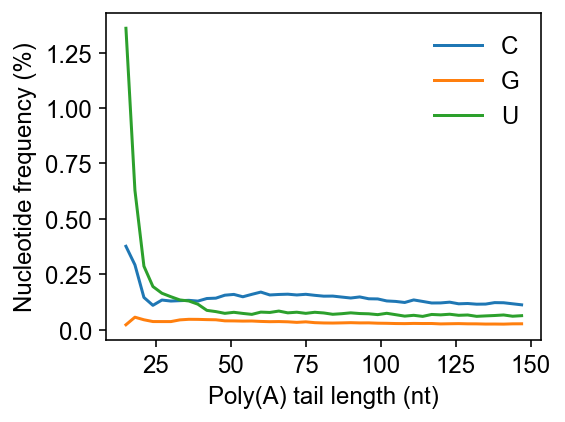

In [170]:
@ticker.FuncFormatter
def formatter(x, pos):
    if x==0:
        return x
    return f'{x*100:0.2f}'
plt.figure(figsize=(3.9, 3))
plt.plot(x, cc, label='C')
plt.plot(x, gg, label='G')
plt.plot(x, tt, label='U')
plt.legend(frameon=False)
plt.ylabel('Nucleotide frequency (%)')
plt.xlabel('Poly(A) tail length (nt)')
plt.gca().get_yaxis().set_major_formatter(formatter)

# nucleotide freq

In [37]:
total_count

Counter({'A': 105438402, 'G': 32653, 'T': 77933, 'C': 143787})

In [171]:
total = total_count['T']+total_count['C']+total_count['G']+total_count['A']
x, y = [], []
for i, base in enumerate(('C', 'G', 'T')):
    x.append(i)
    y.append(total_count[base]/total)

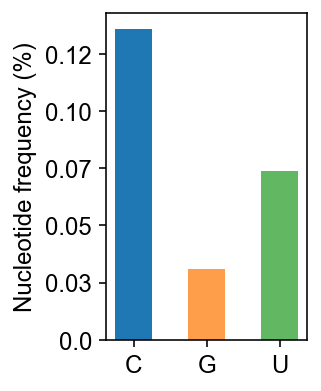

In [176]:
plt.figure(figsize=(1.8, 3))
plt.bar(x, y, width=.5, color=['#1F77B4', '#FF9E4A', '#62B862'])
plt.xticks(x, ['C', 'G', 'U'])
plt.ylabel('Nucleotide frequency (%)')
plt.gca().get_yaxis().set_major_formatter(formatter)

# aligned from 5' end

In [52]:
%%time

infile = '/public/home/mowp/data/total_RNA/pacbio_cdna/polyadenylated_data/totalRNA.polyadenylated.bam'

fwd_nucleotide_pos = defaultdict(lambda: Counter())
with pysam.AlignmentFile(infile, 'rb') as inbam:

    for read in inbam:
        polya_len = read.get_tag('pa')
        read_gene_id = read.get_tag('gi')
        if read.query_name in polya_seq_dict:

            polya_seq = polya_seq_dict[read.query_name]
            for pos, nucleotide in enumerate(polya_seq, 1):
                if pos > 150:
                    break
                fwd_nucleotide_pos[pos][nucleotide] += 1

CPU times: user 2min 54s, sys: 326 ms, total: 2min 54s
Wall time: 2min 54s


In [53]:
x, tt, gg, cc = [], [], [], []
for pos in range(5, 150):
    
    total = fwd_nucleotide_pos[pos]['T']+fwd_nucleotide_pos[pos]['C']+fwd_nucleotide_pos[pos]['G']+fwd_nucleotide_pos[pos]['A']
    if total > 0:
        x.append(pos)
        tt.append(fwd_nucleotide_pos[pos]['T']/total)
        gg.append(fwd_nucleotide_pos[pos]['G']/total)
        cc.append(fwd_nucleotide_pos[pos]['C']/total)

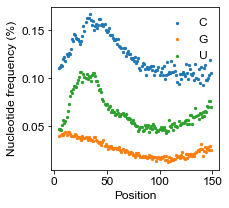

In [54]:
@ticker.FuncFormatter
def formatter(x, pos):
    if x==0:
        return x
    return f'{x*100:0.2f}'

plt.figure(figsize=(3, 3))
plt.scatter(x, cc, label='C', s=5)
plt.scatter(x, gg, label='G', s=5)
plt.scatter(x, tt, label='U', s=5)
plt.legend(frameon=False)
plt.ylabel('Nucleotide frequency (%)')
plt.xlabel('Position')
plt.gca().get_yaxis().set_major_formatter(formatter)

# aligned from 3' end

In [55]:
%%time

infile = '/public/home/mowp/data/total_RNA/pacbio_cdna/polyadenylated_data/totalRNA.polyadenylated.bam'

rev_nucleotide_pos = defaultdict(lambda: Counter())
with pysam.AlignmentFile(infile, 'rb') as inbam:

    for read in inbam:
        polya_len = read.get_tag('pa')
        read_gene_id = read.get_tag('gi')
        if read.query_name in polya_seq_dict:
                
            polya_seq = polya_seq_dict[read.query_name]
            for pos, nucleotide in enumerate(polya_seq[::-1], 1):
                if pos > 150:
                    break
                rev_nucleotide_pos[pos][nucleotide] += 1

CPU times: user 2min 54s, sys: 353 ms, total: 2min 54s
Wall time: 2min 54s


In [177]:
x, tt, gg, cc = [], [], [], []
for pos in range(0, 25):
    
    total = rev_nucleotide_pos[pos]['T']+rev_nucleotide_pos[pos]['C']+rev_nucleotide_pos[pos]['G']+rev_nucleotide_pos[pos]['A']
    if total > 0:
        x.append(pos)
        tt.append(rev_nucleotide_pos[pos]['T']/total)
        gg.append(rev_nucleotide_pos[pos]['G']/total)
        cc.append(rev_nucleotide_pos[pos]['C']/total)

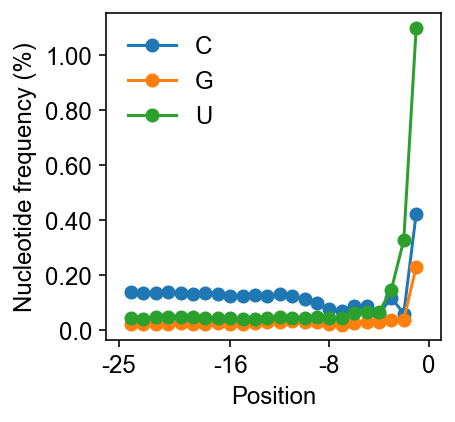

In [178]:
@ticker.FuncFormatter
def formatter(x, pos):
    if x==0:
        return x
    return f'{x*100:0.2f}'
plt.figure(figsize=(3, 3))
# plt.scatter(x, cc, label='C', s=5)
# plt.scatter(x, gg, label='G', s=5)
# plt.scatter(x, tt, label='U', s=5)

plt.plot(x, cc, label='C', marker='o')
plt.plot(x, gg, label='G', marker='o')
plt.plot(x, tt, label='U', marker='o')
plt.legend(frameon=False)
plt.ylabel('Nucleotide frequency (%)')
plt.xlabel('Position')
plt.gca().get_yaxis().set_major_formatter(formatter)
plt.xlim(26, -1)
plt.xticks(np.linspace(0, 25, 4, dtype='int'),  np.linspace(0, 25, 4, dtype='int')*-1)
plt.show()

In [58]:
def plot_freq_pos(ax, x, cc, gg, tt, ylabel=None):
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.set_xlabel('Position')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.scatter(x, cc, label='C', s=5)
    ax.scatter(x, gg, label='G', s=5)
    ax.scatter(x, tt, label='U', s=5)
    ax.yaxis.set_major_formatter(formatter)

    
def get_data(nucleotide_pos, start, end):
    x, tt, gg, cc = [], [], [], []
    for pos in range(start, end):

        total = nucleotide_pos[pos]['T']+nucleotide_pos[pos]['C']+nucleotide_pos[pos]['G']+nucleotide_pos[pos]['A']
        if total > 0:
            x.append(pos)
            tt.append(nucleotide_pos[pos]['T']/total)
            gg.append(nucleotide_pos[pos]['G']/total)
            cc.append(nucleotide_pos[pos]['C']/total)
    return x, tt, gg, cc

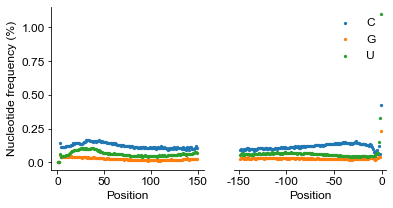

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
x, tt, gg, cc = get_data(fwd_nucleotide_pos, 0, 150)
plot_freq_pos(ax[0], x, cc, gg, tt, ylabel='Nucleotide frequency (%)')
ax[0].set_xticks(np.linspace(0, 150, 4, dtype='int'))


x, tt, gg, cc = get_data(rev_nucleotide_pos, 0, 150)
plot_freq_pos(ax[1], x, cc, gg, tt)
ax[1].spines['left'].set_visible(False)
ax[1].yaxis.set_ticks_position('none')
plt.xlim(155, -5)
plt.xticks(np.linspace(0, 150, 4, dtype='int'),  np.linspace(0, 150, 4, dtype='int')*-1)
plt.setp(ax[1].get_yticklabels(), visible=False)
plt.legend(frameon=False)

# 10-nucleotide sequences

In [179]:
%%time

infile = '/public/home/mowp/data/total_RNA/pacbio_cdna/polyadenylated_data/totalRNA.polyadenylated.bam'

ten_nt_seq_counter = Counter()  # Abundant non-A residues at the 3′ end of the poly(A) tail
with pysam.AlignmentFile(infile, 'rb') as inbam:
    for read in inbam:
        polya_len = read.get_tag('pa')
        read_gene_id = read.get_tag('gi')
        if read.query_name in polya_seq_dict:
            polya_seq = polya_seq_dict[read.query_name][-10: ]
            ten_nt_seq_counter[polya_seq] += 1

CPU times: user 17 s, sys: 455 ms, total: 17.5 s
Wall time: 17.6 s


In [183]:
temp = list(ten_nt_seq_counter.most_common(10))

In [186]:
pd.DataFrame(temp, columns=['Nucleotides', 'Read counts'])

,Nucleotides,Read counts
0,AAAAAAAAAA,1486324
1,AAAAAAAAAT,14024
2,AAAAAAAAAC,6103
3,AAAAAAAAAG,3383
4,AAAAAAAATA,2226
5,AAAAAAAATT,1814
6,AAAAAAACAA,1502
7,AAAAAAATAA,1488
8,CAAAAAAAAA,1289
9,ACAAAAAAAA,1172


In [30]:
%%time

infile = '/public/home/mowp/data/total_RNA/pacbio_cdna/polyadenylated_data/totalRNA.polyadenylated.bam'

last_nucleotide_len = []
with pysam.AlignmentFile(infile, 'rb') as inbam:
    for read in inbam:
        polya_len = read.get_tag('pa')
        read_gene_id = read.get_tag('gi')
        if read.query_name in polya_seq_dict:
            last_nucleotide = polya_seq_dict[read.query_name][-1]
            last_nucleotide_len.append((last_nucleotide, polya_len))

CPU times: user 16 s, sys: 293 ms, total: 16.3 s
Wall time: 16.3 s


In [32]:
last_nucleotide_len = pd.DataFrame(last_nucleotide_len, columns=['nucleotide', 'polya_len'])

In [33]:
last_nucleotide_len = last_nucleotide_len.query('polya_len <= 300')

<AxesSubplot:xlabel='nucleotide', ylabel='polya_len'>

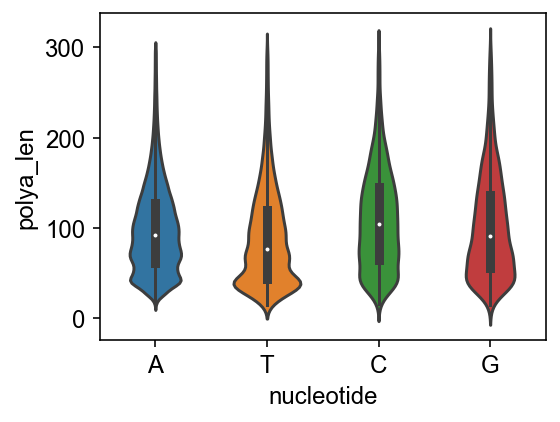

In [126]:
plt.figure(figsize=(4, 3))
sns.violinplot(x='nucleotide', y='polya_len', data=last_nucleotide_len, width=.6)

<AxesSubplot:xlabel='polya_len', ylabel='Density'>

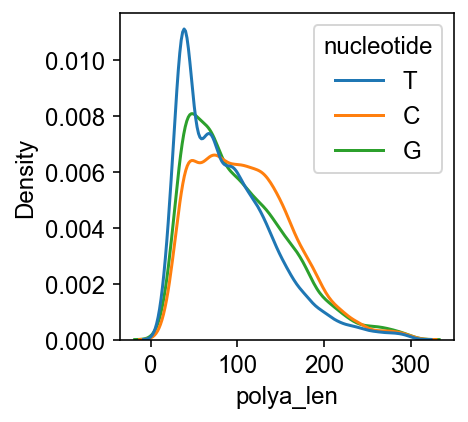

In [125]:
fig, ax = plt.subplots(figsize=(3, 3))
sns.kdeplot(hue='nucleotide', x='polya_len', data=last_nucleotide_len.query('nucleotide != "A"'), common_norm=False, ax=ax)
# ax.legend(frameon=False)